In [1]:
import os 
os.chdir("/home/canyon/Bus-Weather-Impacts")
from src.utils import *
import pandas as pd
import os
import osmnx as ox
import numpy as np
import geopandas as gpd
import networkx as nx
from sklearn.neighbors import KDTree
import numpy as np
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:.02f}'.format)
from geopy.distance import geodesic
from shapely.ops import linemerge
pd.set_option('display.float_format', lambda x: '%.6f' % x)
pd.set_option('display.max_columns', None)
import contextily as ctx
from src.api import parse_zipped_gtfs
import matplotlib.pyplot as plt
from src.gtfs_segments import GTFS_shape_processor

In [65]:
segments_with_lanes = gpd.read_file("/home/data/bus-weather/bus_lane_route_segments.geojson")
segments = gpd.read_parquet("/home/data/bus-weather/bus_segments_2023_09_18.parquet")

In [66]:
segments = segments.merge(segments_with_lanes[["shape_id", "stop_id", "prev_stop_id", "Open_dates", "Hours", "Days"]], how = "left")

In [67]:
gtfs_speed = read_speeds_between_dates("2023-09-18", "2023-10-30").query("speed_mph < 70 & speed_mph > 0")
full_trips = pd.read_parquet("/home/data/bus-weather/nyc_trip_shapes.parquet")
gtfs_speed = full_trips.merge(gtfs_speed)

In [68]:
feed = parse_zipped_gtfs("https://transitfeeds.com/p/mta/82/20230919/download")

In [69]:
def plot_gdfs_with_basemap(gdfs, crs='EPSG:3857', figsize=(20, 20), colors=None):
    fig, ax = plt.subplots(figsize=figsize)

    if colors is None:
        colors = plt.cm.get_cmap('tab10', len(gdfs)).colors  

    for idx, gdf in enumerate(gdfs):
        gdf = gdf.to_crs(crs)  
        gdf.plot(ax=ax, color=colors[idx % len(colors)], label=f'GeoDataFrame {idx + 1}', linewidth = 3)

    ctx.add_basemap(ax, crs=crs, source=ctx.providers.OpenStreetMap.Mapnik)

    ax.legend()

    plt.show()


In [70]:
feed["trips.txt"].query("route_id == 'M96'")["shape_id"].drop_duplicates()

3593    M960093
3647    M960003
Name: shape_id, dtype: object

In [71]:
shape = "M960093"

/tmp/ipykernel_26640/1900357064.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(gdfs)).colors


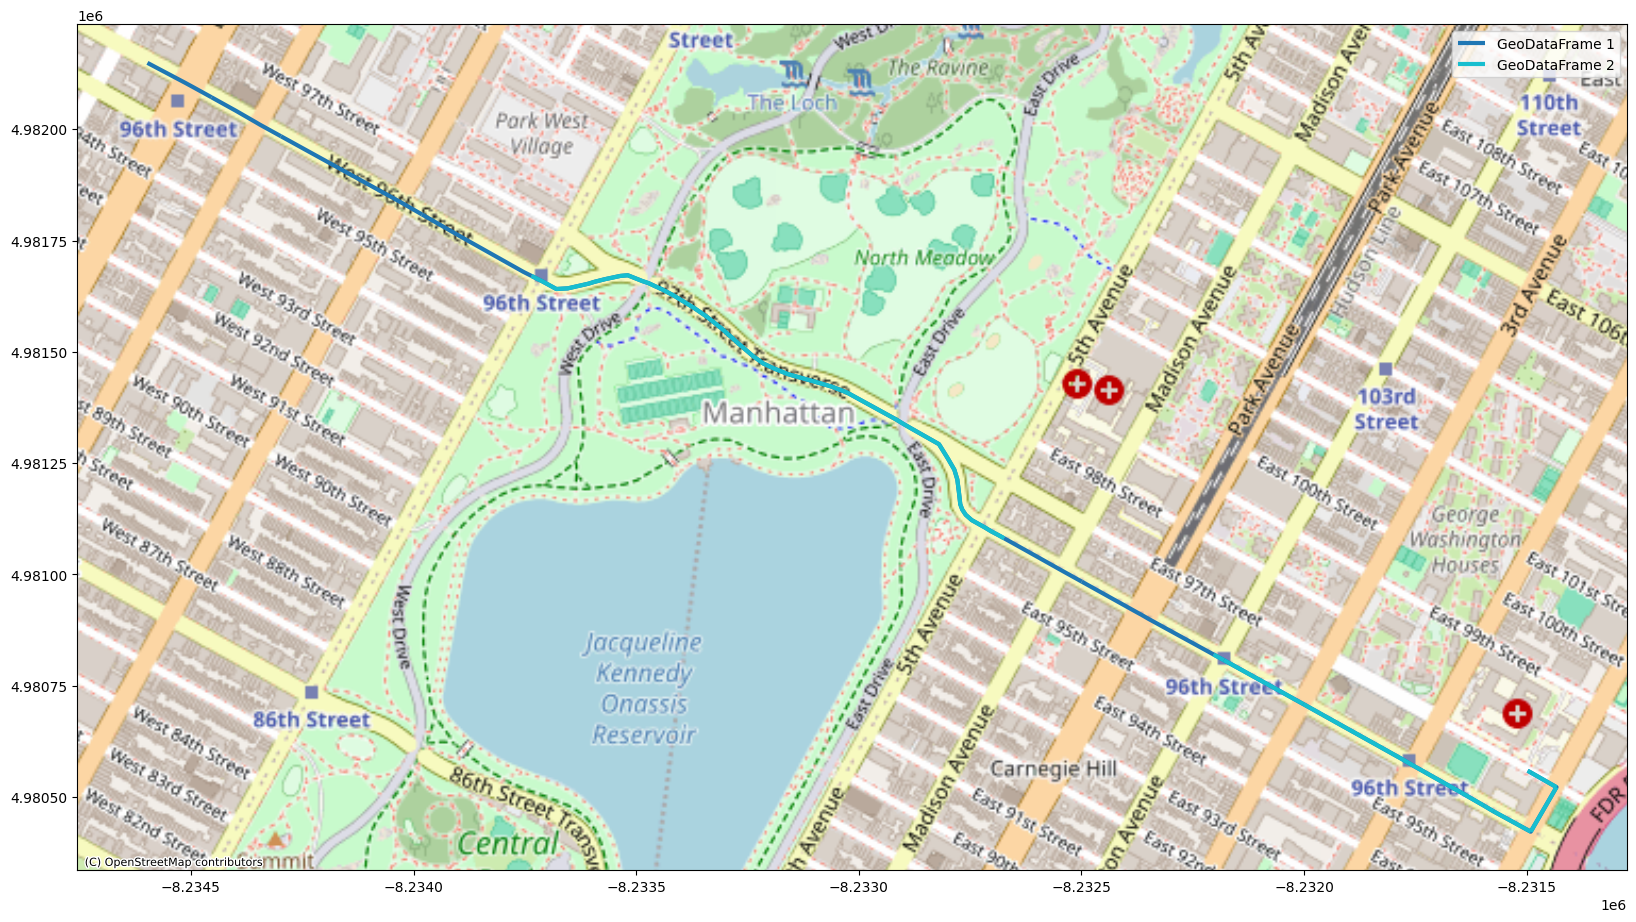

In [72]:
plot_gdfs_with_basemap([segments.query("shape_id == @shape"), segments_with_lanes.query("shape_id == @shape")])

In [80]:
segments["bus_lane"] = ~segments["Open_dates"].isna()
segments["open_september"] = (segments["Open_dates"] == "2023-09-26")

In [81]:
gtfs_speed = gtfs_speed.merge(segments[["shape_id", "stop_id", "prev_stop_id", "Open_dates", "bus_lane", "open_september"]])

In [75]:
gtfs_speed.groupby(["route_id", "shape_id", "bus_lane"]).agg(average_speed = ("speed_mph", "median")).reset_index().pivot_table(values = "average_speed", columns = "bus_lane", index = ["route_id", "shape_id"]).reset_index().query("route_id == 'M96'")

bus_lane route_id shape_id    False     True
841           M96  M960003 4.164185 4.792317
842           M96  M960093 4.589071 5.960830

In [85]:
september_comp = gtfs_speed.query("open_september")
september_comp["pre"] = september_comp["interpolated_time"] < pd.to_datetime("2023-09-26")

In [88]:
september_comp.groupby(["route_id", "pre"]).agg(average_speed = ("speed_mph", "median")).reset_index()

route_id    pre  average_speed
0      BXM1  False       8.681936
1      BXM1   True       8.251423
2      M101  False       8.263807
3      M101   True       8.483541
4      M102  False       6.322639
5      M102   True       6.221412
6      M103  False       6.154470
7      M103   True       6.120912
8       M66  False       4.459289
9       M66   True       4.430704
10      M72  False       4.703388
11      M72   True       4.631836
12     M86+  False       4.531433
13     M86+   True       4.514657
14      M96  False       4.156919
15      M96   True       4.085248
16      M98  False       8.003157
17      M98   True       7.695626
18    SIM11  False       9.478276
19    SIM11   True      10.920623
20     SIM6  False       9.051327
21     SIM6   True       9.568545

/tmp/ipykernel_26640/1900357064.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(gdfs)).colors


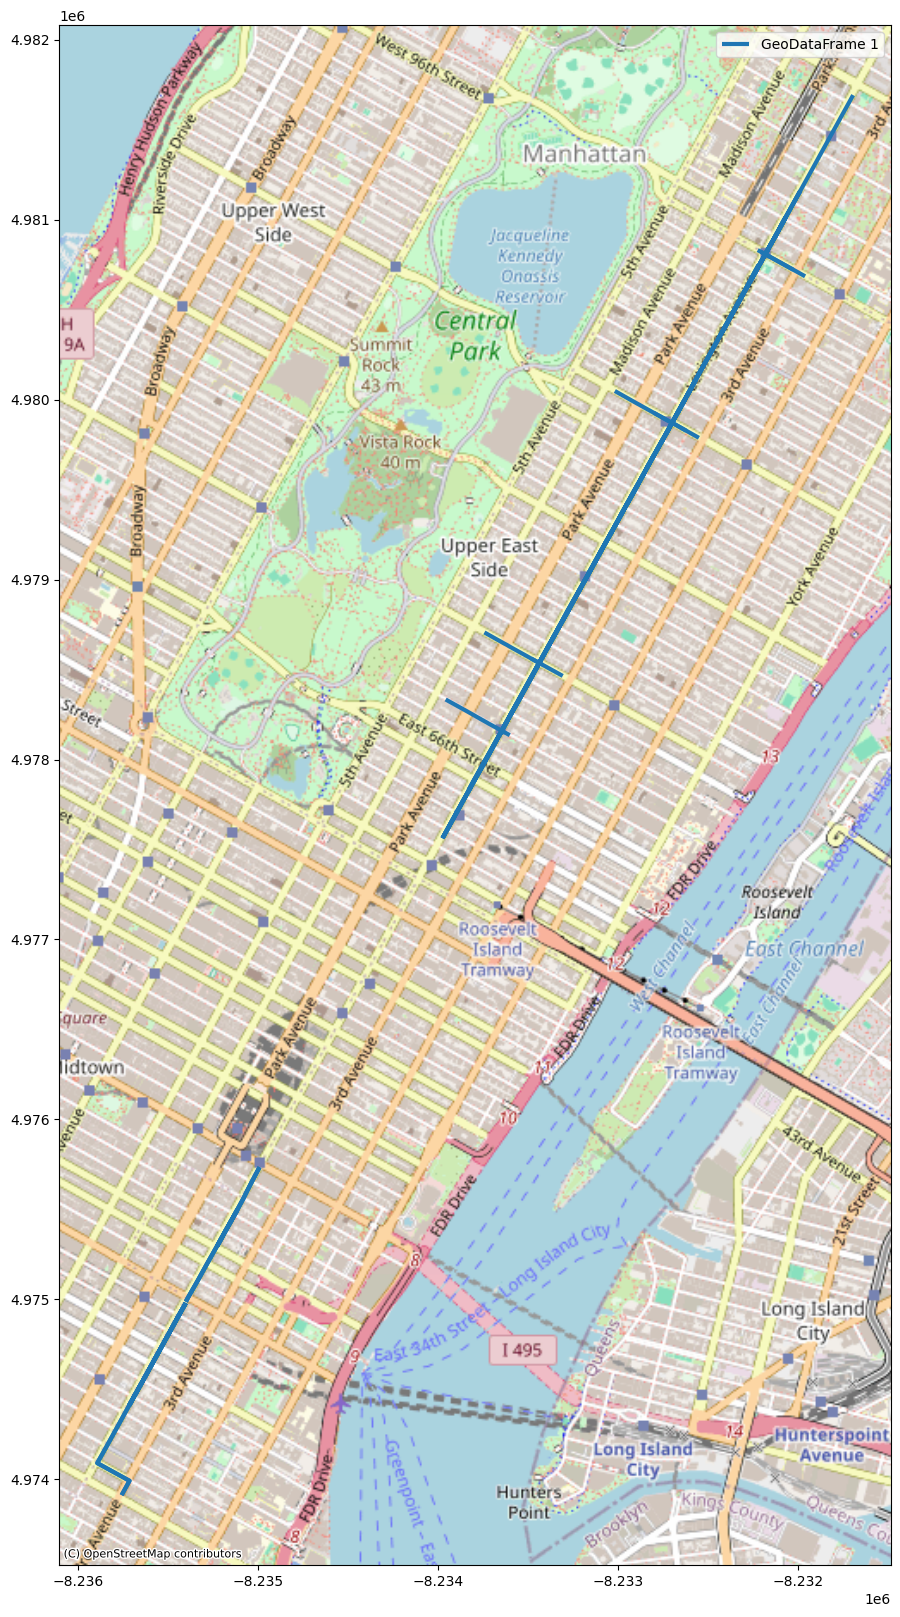

In [90]:
plot_gdfs_with_basemap([segments.query("open_september")])